In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.mu_layer = nn.Linear(64, latent_dim)
        self.log_var_layer = nn.Linear(64, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        log_var = self.log_var_layer(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def decode(self, z, original_x):
        # Decode the latent variable to reconstruct -x + ε
        reconstruction = self.decoder(z)
        noise = torch.randn_like(original_x)
        return -original_x + noise + reconstruction

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z, x)
        return recon_x, mu, log_var


# Loss function
def vae_loss(recon_x, x, mu, log_var):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, -x, reduction='sum')
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_loss


# Example usage
input_dim = 10  # Dimensionality of the input
latent_dim = 2  # Dimensionality of the latent space
vae = VAE(input_dim, latent_dim)

# Example input
x = torch.randn(16, input_dim)  # Batch of 16 samples
recon_x, mu, log_var = vae(x)
loss = vae_loss(recon_x, x, mu, log_var)
print(f"Loss: {loss.item()}")


Loss: 170.68450927734375


In [8]:
class NegativeMappingDataset(Dataset):
    def __init__(self, num_samples, input_dim, noise_std=0.1):
        """
        Args:
            num_samples (int): Number of samples in the dataset.
            input_dim (int): Dimensionality of the input data.
            noise_std (float): Standard deviation of the noise.
        """
        super().__init__()
        self.num_samples = num_samples
        self.input_dim = input_dim
        self.noise_std = noise_std
        
        # Generate random input data
        self.x = torch.randn(num_samples, input_dim)
        
        # Generate targets as -x + epsilon
        noise = torch.randn_like(self.x) * noise_std
        self.y = -self.x + noise

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [10]:
# Parameters
num_samples = 1000  # Total number of samples
input_dim = 10      # Dimensionality of the input
noise_std = 0.1     # Standard deviation of the noise

# Create dataset and data loader
dataset = NegativeMappingDataset(num_samples, input_dim, noise_std)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Visualize some samples
for x, y in dataloader:
    print("Input (x):", x[:3])  # First 3 inputs
    print("Target (y):", y[:3])  # Corresponding targets
    break


Input (x): tensor([[-0.5798,  0.1858,  0.1110,  0.5067, -1.0579,  0.8944, -1.3131, -0.8988,
         -0.8798, -0.8492],
        [ 1.1229, -0.7155, -0.6460,  1.9507,  0.6961,  2.3689, -0.2073, -0.9066,
         -0.4622,  1.1071],
        [-1.0125,  0.4987, -0.8765, -0.0580, -1.0716, -1.3523,  0.0915,  0.1551,
          1.5044,  1.0935]])
Target (y): tensor([[ 0.4899, -0.2409, -0.0709, -0.4044,  1.0866, -0.8610,  1.3575,  0.9004,
          0.8717,  0.8292],
        [-1.0515,  1.0039,  0.4970, -1.8934, -0.6331, -2.4084,  0.1070,  0.9301,
          0.4963, -1.1139],
        [ 0.9745, -0.4764,  0.8351, -0.0495,  1.0339,  1.4451, -0.0807, -0.1413,
         -1.4585, -1.2211]])


In [12]:
epochs = 50
batch_size = 32
learning_rate = 1e-3

num_samples = 1000  # Total number of samples
input_dim = 10      # Dimensionality of the input
noise_std = 0.1     # Standard deviation of the noise

# Create dataset and data loader
dataset = NegativeMappingDataset(num_samples, input_dim, noise_std)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model, optimizer
vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Training loop
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        x = batch[0]  # Input batch
        optimizer.zero_grad()
        
        # Forward pass
        recon_x, mu, log_var = vae(x)
        
        # Compute loss
        loss = vae_loss(recon_x, x, mu, log_var)
        total_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Logging
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

print("Training complete.")


Epoch 1/50, Loss: 9.8922
Epoch 2/50, Loss: 9.9204
Epoch 3/50, Loss: 10.0652
Epoch 4/50, Loss: 9.9917
Epoch 5/50, Loss: 9.8686
Epoch 6/50, Loss: 10.2252
Epoch 7/50, Loss: 10.0218
Epoch 8/50, Loss: 10.0768
Epoch 9/50, Loss: 10.2880
Epoch 10/50, Loss: 9.9256
Epoch 11/50, Loss: 9.8152
Epoch 12/50, Loss: 9.9612
Epoch 13/50, Loss: 10.1241
Epoch 14/50, Loss: 9.7731
Epoch 15/50, Loss: 9.9784
Epoch 16/50, Loss: 9.9494
Epoch 17/50, Loss: 10.1260
Epoch 18/50, Loss: 10.0917
Epoch 19/50, Loss: 9.7301
Epoch 20/50, Loss: 10.0883
Epoch 21/50, Loss: 10.1857
Epoch 22/50, Loss: 10.2863
Epoch 23/50, Loss: 9.9609
Epoch 24/50, Loss: 9.8942
Epoch 25/50, Loss: 10.1163
Epoch 26/50, Loss: 10.0007
Epoch 27/50, Loss: 10.2983
Epoch 28/50, Loss: 10.0167
Epoch 29/50, Loss: 9.9075
Epoch 30/50, Loss: 10.1736
Epoch 31/50, Loss: 10.2272
Epoch 32/50, Loss: 10.0712
Epoch 33/50, Loss: 10.0796
Epoch 34/50, Loss: 9.9662
Epoch 35/50, Loss: 9.9301
Epoch 36/50, Loss: 9.9472
Epoch 37/50, Loss: 10.0972
Epoch 38/50, Loss: 9.8139
E

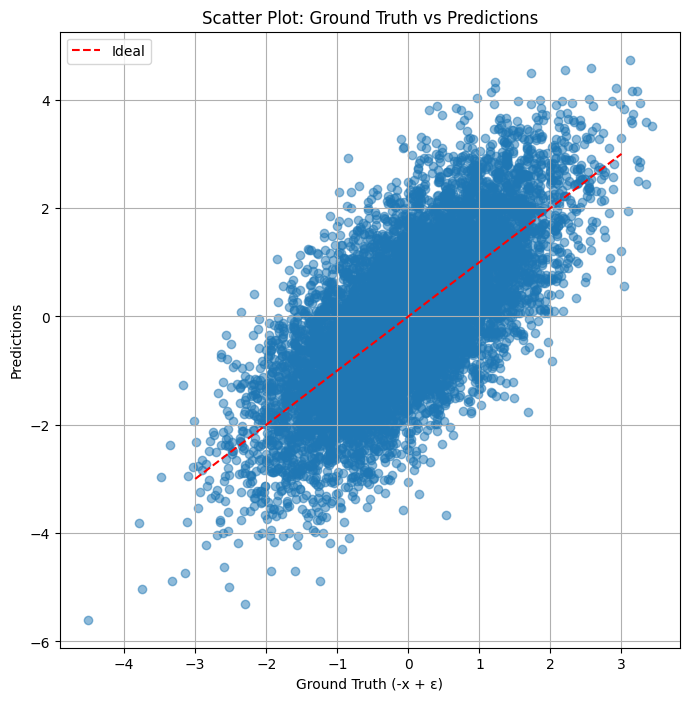

In [15]:
import matplotlib.pyplot as plt

# Ensure VAE is in evaluation mode
vae.eval()

# Collect predictions and ground truths
predictions = []
ground_truths = []

with torch.no_grad():
    for x, y in dataloader:
        recon_x, _, _ = vae(x)
        predictions.append(recon_x)
        ground_truths.append(y)

# Concatenate all batches into a single tensor
predictions = torch.cat(predictions, dim=0)
ground_truths = torch.cat(ground_truths, dim=0)

# Convert to numpy for plotting
predictions_np = predictions.numpy()
ground_truths_np = ground_truths.numpy()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(ground_truths_np.flatten(), predictions_np.flatten(), alpha=0.5)
plt.plot([-3, 3], [-3, 3], color='red', linestyle='--', label='Ideal')  # Diagonal line for reference
plt.title("Scatter Plot: Ground Truth vs Predictions")
plt.xlabel("Ground Truth (-x + ε)")
plt.ylabel("Predictions")
plt.legend()
plt.grid()
plt.show()
